In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
print(sns.__version__)
import matplotlib.pyplot as plt
from itertools import combinations
import os
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import matplotlib
matplotlib.rcParams['font.family'] = 'FreeSans'

calphad_results_dir = './v6_A-B-C-D-E_Sputtering/'
print("calphad results directory:", os.path.abspath(calphad_results_dir))

ML_results_dir = './v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All_Calc/'
print("")
print("ML results directory:", os.path.abspath(ML_results_dir))

0.12.2
calphad results directory: /home/yuxiangw/Yuxiang/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering

ML results directory: /home/yuxiangw/Yuxiang/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering_ML/v6_A-B-C-D-E_Sputtering_ML_All_Calc


### Creating lists of compositions and labels


In [57]:
# Define the set of elements for D and E
set_D_E = [{'Co'}, {'V'}, {'Mn'}, {'Mo'}, {'Cu'},
           {'Nb'}, {'W'}, {'Ti'}, {'Al'}, {'Si'}, {'Ta'}]

# Generate all possible combinations of D and E
compo_D_E_list = list(combinations(set_D_E, 2))

compo_A_B_C_D_E_list = []
compo_A_B_C_D_E_label_list = []

for compo_D_E in compo_D_E_list:
    # Convert the current combination to a list and flatten it
    compo_D_E_list = [item for sublist in compo_D_E for item in sublist]

    # Define the current combination of A, B, C, D, E
    compo_A_B_C_D_E = ['Fe', 'Cr', 'Ni'] + compo_D_E_list
    compo_A_B_C_D_E_merge = '_'.join([*compo_A_B_C_D_E])

    compo_A_B_C_sorted = sorted(['Fe', 'Cr', 'Ni'])
    compo_D_E_list_sorted = sorted(compo_D_E_list)
    compo_A_B_C_D_E_label_sorted_merge = '(' + '-'.join(
        [*compo_A_B_C_sorted]) + ')-(' + '-'.join([*compo_D_E_list_sorted]) + ')'

    # compo_A_B_C_D_E_label_merge = '-'.join([*compo_A_B_C_D_E])

    compo_A_B_C_D_E_list.append(compo_A_B_C_D_E_merge)
    compo_A_B_C_D_E_label_list.append(compo_A_B_C_D_E_label_sorted_merge)

# --- do we include Fe_Cr_Ni -----
compo_A_B_C_D_E_list.append('Fe_Cr_Ni')
compo_A_B_C_D_E_label_list.append('(Cr-Fe-Ni)')
# --------------------------------

print("compo_A_B_C_D_E_list : ", compo_A_B_C_D_E_list[0])
print("compo_A_B_C_D_E_label_list: ", compo_A_B_C_D_E_label_list[0])

full_path = os.path.abspath(calphad_results_dir + 'v6_' +
                            compo_A_B_C_D_E_list[0] + '_Sputtering' + '/count_fcc_fractions_byPalette.xlsx')
print("Full path:", full_path)

compo_A_B_C_D_E_list :  Fe_Cr_Ni_Co_V
compo_A_B_C_D_E_label_list:  (Cr-Fe-Ni)-(Co-V)
Full path: /home/yuxiangw/Yuxiang/CCA_CALPHAD_SSS_ML/v6_A-B-C-D-E_Sputtering/v6_Fe_Cr_Ni_Co_V_Sputtering/count_fcc_fractions_byPalette.xlsx


In [58]:
# sorted(compo_D_E_list)
# sorted(['Fe', 'Cr', 'Ni'])
compo_A_B_C_sorted = sorted(['Fe', 'Cr', 'Ni'])
compo_D_E_list_sorted = sorted(compo_D_E_list)
compo_A_B_C_D_E_label_sorted_merge = '(' + '-'.join(
    [*compo_A_B_C_sorted]) + ')-(' + '-'.join([*compo_D_E_list_sorted]) + ')'
compo_A_B_C_D_E_label_sorted_merge

'(Cr-Fe-Ni)-(Si-Ta)'

### Reads in relevant data, performs data manipulations, and saves the updated dataframes to files


In [59]:
# Define a list of compositions to iterate over
# compo_A_B_C_D_E_list = ['Fe_Cr_Ni_Mn_Ta', 'Fe_Cr_Ni_Mn_Ti', 'Fe_Cr_Ni_Mn_W']

# Initialize lists to hold dataframes
fcc_fractions_byPalette_list = []
SSS_fcc_byCompo_list = []
H1_C2_mean_std_fcc_byCompo_list = []


def process_composition(compo_A_B_C_D_E_fname, compo_A_B_C_D_E_label):

    # ----- read `count_fcc_fractions_byPalette` -----
    # Read in the FCC phase stability dataframe and add composition label
    fcc_fractions_byPalette = pd.read_excel(calphad_results_dir +
                                            'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byPalette.xlsx')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Add labels for FCC phase stability types
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        Gmin_FCC='min Gibbs energy')
    fcc_fractions_byPalette = fcc_fractions_byPalette.assign(
        eq_FCC='full equilibrium')

    # Append the updated dataframe to the list
    fcc_fractions_byPalette_list.append(fcc_fractions_byPalette)

    # ----- Read `SSS_byCompo` and `count_fcc_fractions_byCompo` -----
    # Read in the SSS and FCC fractions by composition dataframes
    SSS_byCompo = pd.read_excel(calphad_results_dir +
                                'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_byCompo.xlsx')
    fcc_fractions_byCompo = pd.read_excel(calphad_results_dir +
                                          'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/count_fcc_fractions_byCompo.xlsx')

    # Merge the two dataframes
    SSS_fcc_byCompo = pd.concat([SSS_byCompo, fcc_fractions_byCompo[[
                                'Gmin_FCC', 'eq_FCC', 'Gmin_eq_FCC']]], axis=1)

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    SSS_fcc_byCompo['sigma_SSS_FCC'] = SSS_fcc_byCompo.loc[SSS_fcc_byCompo['Gmin_eq_FCC'] == 1, 'sigma_SSS']
    SSS_fcc_byCompo = SSS_fcc_byCompo.assign(
        compo_A_B_C_D_E=compo_A_B_C_D_E_label)

    # Saving the new `SSS_FCC_byCompo.xlsx`
    if os.path.exists(calphad_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx'):
        print('SSS_FCC_byCompo.xlsx: File already exists.')
    else:
        SSS_fcc_byCompo.to_excel(calphad_results_dir +
                                 'v6_' + compo_A_B_C_D_E_fname + '_Sputtering' + '/SSS_FCC_byCompo.xlsx', index=False)
        print('Saving '+'v6_' + compo_A_B_C_D_E_fname +
              '_Sputtering' + '/SSS_FCC_byCompo.xlsx')

    # Append the updated dataframe to the list
    SSS_fcc_byCompo_list.append(SSS_fcc_byCompo)

    # ----------------------------------------------------------------------------------------------------

    H1_C2_mean_std_fcc_byCompo = pd.read_excel(
        ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML.xlsx')

    # Create a new column 'sigma_SSS_FCC' for SSS values corresponding to FCC phase stability
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['H1_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'H1_new_pred_KFold_std']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_mean_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_mean']
    H1_C2_mean_std_fcc_byCompo['C2_new_pred_KFold_std_FCC'] = H1_C2_mean_std_fcc_byCompo.loc[
        H1_C2_mean_std_fcc_byCompo['Gmin_eq_FCC'] == 1, 'C2_new_pred_KFold_std']

    # Saving the excel: H1 C2 when FCC==1
    if os.path.exists(ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx'):
        print('SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.')
    else:
        H1_C2_mean_std_fcc_byCompo.to_excel(
            ML_results_dir + 'v6_' + compo_A_B_C_D_E_fname + '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')
        print('Saving ' + 'v6_' + compo_A_B_C_D_E_fname +
              '_SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx')

    # Append the updated dataframe to the list
    H1_C2_mean_std_fcc_byCompo_list.append(H1_C2_mean_std_fcc_byCompo)

    # Return your results
    return fcc_fractions_byPalette, SSS_fcc_byCompo, H1_C2_mean_std_fcc_byCompo


# ----------------------------------------------------------------------------------------------------
# Use ProcessPoolExecutor to run the loop in parallel
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_composition, compo_A_B_C_D_E_list,
                   compo_A_B_C_D_E_label_list), total=len(compo_A_B_C_D_E_list)))

# Unpack the results into your lists
for result in results:
    fcc_fractions_byPalette_list.append(result[0])
    SSS_fcc_byCompo_list.append(result[1])
    H1_C2_mean_std_fcc_byCompo_list.append(result[2])

# Display the first two rows of the loaded dataframes
display(fcc_fractions_byPalette_list[0].head(2))
display(SSS_fcc_byCompo_list[0].head(2))
display(H1_C2_mean_std_fcc_byCompo_list[0].head(2))

  0%|          | 0/56 [00:00<?, ?it/s]

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byC

  2%|▏         | 1/56 [00:03<03:34,  3.91s/it]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


  9%|▉         | 5/56 [00:04<00:32,  1.59it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


 14%|█▍        | 8/56 [00:04<00:17,  2.80it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.

SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exists.
SSS_FCC_byCompo.xlsx: File already exist

 59%|█████▉    | 33/56 [00:06<00:02,  8.21it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.



 64%|██████▍   | 36/56 [00:06<00:02,  8.76it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


 71%|███████▏  | 40/56 [00:06<00:01, 10.23it/s]

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.

SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.
SSS_FCC_byCompo_wt_pct_ML_fcc.xlsx: File already exists.


100%|██████████| 56/56 [00:06<00:00,  8.33it/s]


,ABCDE,Gmin_FCC_fraction,eq_FCC_fraction,Gmin_eq_FCC_fraction,Unnamed: 4,compo_A_B_C_D_E,Gmin_FCC,eq_FCC
0,V-Co-Ni-Cr-Fe,57.971014,44.927536,44.927536,NaN,(Cr-Fe-Ni)-(Co-V),min Gibbs energy,full equilibrium
1,V-Co-Ni-Fe-Cr,55.072464,52.173913,49.275362,NaN,(Cr-Fe-Ni)-(Co-V),min Gibbs energy,full equilibrium


,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,ABCDE,Gmin_FCC,eq_FCC,Gmin_eq_FCC,sigma_SSS_FCC,compo_A_B_C_D_E
0,0.33,0.03,0.05,0.12,0.47,63.740744,0.329844,0.092273,456.766541,V-Co-Ni-Cr-Fe,0,0.0,0,NaN,(Cr-Fe-Ni)-(Co-V)
1,0.39,0.05,0.05,0.11,0.40,66.837689,0.322980,0.091240,464.791066,V-Co-Ni-Cr-Fe,0,0.0,0,NaN,(Cr-Fe-Ni)-(Co-V)


,Unnamed: 0,Fe,Cr,Ni,Co,V,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,sigma_SSS_FCC,compo_A_B_C_D_E,H1_new_pred_KFold_mean,H1_new_pred_KFold_std,C2_new_pred_KFold_mean,C2_new_pred_KFold_std,H1_new_pred_KFold_mean_FCC,H1_new_pred_KFold_std_FCC,C2_new_pred_KFold_mean_FCC,C2_new_pred_KFold_std_FCC
0,0,34.167395,2.891940,5.441344,13.111107,44.388214,63.740744,0.329844,0.092273,456.766541,...,NaN,Fe-Cr-Ni-Co-V,501.462250,121.009743,299.628906,225.678894,NaN,NaN,NaN,NaN
1,1,40.204113,4.798947,5.417690,11.966268,37.612981,66.837689,0.322980,0.091240,464.791066,...,NaN,Fe-Cr-Ni-Co-V,492.357391,119.546692,312.933289,225.030975,NaN,NaN,NaN,NaN


### Rank the sequence of ABCDE by `Gmin_eq_FCC_max`


In [60]:
# fcc_fractions_byPalette_list[0]

In [61]:
# ----- rank by `Gmin_eq_FCC_mean`
# # Calculate the mean of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
# Gmin_eq_FCC_mean = [np.mean(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)
#                     for fcc_fractions_byPalette in fcc_fractions_byPalette_list]
# print(Gmin_eq_FCC_mean)

# ranked_indices = np.argsort(Gmin_eq_FCC_mean)[::-1]  # Sort in descending order

# Gmin_eq_FCC_mean_sort = [Gmin_eq_FCC_mean[i] for i in ranked_indices]  # Sort the mean values in the ranked order
# print(Gmin_eq_FCC_mean_sort)


# ----- rank by `Gmin_eq_FCC_max`: maximum FCC fraction on a wafer
# Calculate the max of the Gmin_eq_FCC_fraction for each set of data and rank them in descending order
Gmin_eq_FCC_max = [np.max(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values) + np.mean(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)*1e-5
                   for fcc_fractions_byPalette in fcc_fractions_byPalette_list]

# # ----- here to get the maximum value: the "whisker" of the boxplot, which typically extends to 1.5 * IQR
# # ----- this gives the max_value to be unique, the above function gives many same values for different systems
# Gmin_eq_FCC_max = []  # Initialize an empty list

# for fcc_fractions_byPalette in fcc_fractions_byPalette_list:

#     # max_value = np.max(fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values)

#     # ---------------------------------------------
#     values = fcc_fractions_byPalette['Gmin_eq_FCC_fraction'].values

#     Q1 = np.percentile(values, 25)
#     Q3 = np.percentile(values, 75)

#     # Step 2: Calculate IQR
#     IQR = Q3 - Q1

#     # Step 3: Calculate the upper whisker limit
#     upper_whisker = Q3 + 1.5 * IQR

#     # Step 4: Find the maximum value within the upper whisker limit
#     # Filter values within the upper whisker limit and take the max
#     # filtered_values = values[values <= upper_whisker]
#     # max_value = np.max(filtered_values) if len(filtered_values) > 0 else None
#     max_value = upper_whisker
#     # ---------------------------------------------

#     Gmin_eq_FCC_max.append(max_value)

print(Gmin_eq_FCC_max)

ranked_indices = np.argsort(Gmin_eq_FCC_max)[::-1]  # Sort in descending order
# print(ranked_indices)

# Sort the mean values in the ranked order
Gmin_eq_FCC_max_sort = [Gmin_eq_FCC_max[i] for i in ranked_indices]
print(Gmin_eq_FCC_max_sort)

# Sort the list of dataframes based on the ranked order of mean values
compo_A_B_C_D_E_sort_list = [compo_A_B_C_D_E_list[i] for i in ranked_indices]
# print(compo_A_B_C_D_E_list)
print(compo_A_B_C_D_E_sort_list)

fcc_fractions_byPalette_sort_list = [
    fcc_fractions_byPalette_list[i] for i in ranked_indices]
SSS_fcc_byCompo_sort_list = [SSS_fcc_byCompo_list[i] for i in ranked_indices]

H1_C2_mean_std_fcc_byCompo_sort_list = [
    H1_C2_mean_std_fcc_byCompo_list[i] for i in ranked_indices]

[50.72495905797101, 79.71065966183575, 17.39137543133195, 34.78276473429951, 17.39134299516908, 24.637772584541064, 30.434901086956526, 36.23205700483092, 43.47847693236715, 17.391347584541062, 28.985654710144928, 18.840640579710147, 21.7392, 11.594225, 10.144949033816426, 11.59423538647343, 15.942079589371978, 18.84063888888889, 7.246386956521739, 36.232046135265705, 44.9278265700483, 13.043506521739129, 15.942070893719805, 24.637773913043482, 30.43487632850242, 26.087039009661833, 11.594221859903381, 23.188479468599034, 8.695664130434782, 5.797107729468599, 11.594221739130434, 17.39134951690821, 10.144945652173913, 4.34782922705314, 10.144946497584542, 8.69566038647343, 18.84063888888889, 21.73918502415459, 15.94206533816425, 4.347827898550724, 4.347828502415458, 2.898552415458937, 8.695662681159419, 2.8985519323671496, 0.0, 4.347828743961353, 5.7971070048309175, 2.898552053140097, 1.449275845410628, 11.594227415458937, 11.594227415458937, 1.4492754830917873, 14.492782487922705, 8.69

### Modify the dataframe for plotting: `fcc_fractions_byPalette_sort_list`


In [62]:
# Create an empty list to store the modified dataframes
df_fcc_byPalette_sns_new_list = []

# Loop over each dataframe in the list of sorted FCC fractions by palette
for df_fcc_byPalette_sns in fcc_fractions_byPalette_sort_list:

    # Select the desired columns for the first dataframe and rename the columns
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns[['ABCDE', 'Gmin_FCC_fraction', 'Gmin_FCC',
                                                  'Gmin_eq_FCC_fraction', 'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns1 = df_fcc_byPalette_sns1.rename(
        columns={'Gmin_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Select the desired columns for the second dataframe and rename the columns
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns[['ABCDE', 'eq_FCC_fraction', 'eq_FCC',
                                                  'compo_A_B_C_D_E']]
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC': 'minG vs.full equil.'})
    df_fcc_byPalette_sns2 = df_fcc_byPalette_sns2.rename(
        columns={'eq_FCC_fraction': 'Gmin_vs_eq_FCC_fraction'})

    # Concatenate the two dataframes vertically
    df_fcc_byPalette_sns_new = pd.concat(
        [df_fcc_byPalette_sns1, df_fcc_byPalette_sns2], axis=0)

    # Add the modified dataframe to the list
    df_fcc_byPalette_sns_new_list.append(df_fcc_byPalette_sns_new)

### Check dataframes to be plotted

- `df_fcc_sns`
- `df_fcc_sns_35`
- `df_SSS_sns`
- `df_SSS_sns_35`
- `df_H1_C2_sns`
- `df_H1_C2_sns_35`


In [63]:
# Concatenate the modified dataframes in the list vertically to create a new dataframe
df_fcc_sns = pd.concat(df_fcc_byPalette_sns_new_list, axis=0)
df_fcc_sns_35 = pd.concat(df_fcc_byPalette_sns_new_list[0:35], axis=0)

# Concatenate the list of SSS dataframes vertically to create a new dataframe
df_SSS_sns = pd.concat(SSS_fcc_byCompo_sort_list, axis=0)
df_SSS_sns_35 = pd.concat(SSS_fcc_byCompo_sort_list[0:35], axis=0)

# Concatenate the list of H1_C2 dataframes vertically to create a new dataframe
df_H1_C2_sns = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list, axis=0)
df_H1_C2_sns_35 = pd.concat(H1_C2_mean_std_fcc_byCompo_sort_list[0:35], axis=0)

# Display the first row of the new SSS dataframe
display('df_fcc_sns', df_fcc_sns.head(1))
display('df_SSS_sns', df_SSS_sns.head(1))
display(df_H1_C2_sns.head(1))
display(df_H1_C2_sns.columns)

'df_fcc_sns'

,ABCDE,Gmin_vs_eq_FCC_fraction,minG vs.full equil.,Gmin_eq_FCC_fraction,compo_A_B_C_D_E
0,Mn-Co-Ni-Cr-Fe,60.869565,min Gibbs energy,59.42029,(Cr-Fe-Ni)-(Co-Mn)


'df_SSS_sns'

,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,...,V,ABCDE,Cu,Si,Al,Mo,Ti,W,Ta,Nb
0,0.33,0.03,0.05,0.12,0.47,81.342074,0.266533,0.041722,133.665273,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Unnamed: 0,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,...,C2_new_pred_KFold_std_FCC,V,Cu,Si,Al,Mo,Ti,W,Ta,Nb
0,0,33.017598,2.794621,5.258233,12.669893,46.259655,81.342074,0.266533,0.041722,133.665273,...,153.246796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FCC', 'H1_new_pred_KFold_std_FCC',
       'C2_new_pred_KFold_mean_FCC', 'C2_new_pred_KFold_std_FCC', 'V', 'Cu',
       'Si', 'Al', 'Mo', 'Ti', 'W', 'Ta', 'Nb'],
      dtype='object')

In [64]:
df_SSS_sns_35.head()
df_SSS_sns_35

,Fe,Cr,Ni,Co,Mn,ShearModulus_eff,PoissonsRatio_eff,delta_prime_misfit,sigma_SSS,Gmin_FCC,...,V,ABCDE,Cu,Si,Al,Mo,Ti,W,Ta,Nb
0,0.33,0.03,0.05,0.12,0.47,81.342074,0.266533,0.041722,133.665273,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.39,0.05,0.05,0.11,0.40,82.098760,0.269039,0.040988,132.214005,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.44,0.07,0.04,0.10,0.34,82.919621,0.270346,0.039650,126.799735,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.49,0.11,0.04,0.09,0.27,84.330599,0.271172,0.038259,122.241351,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.53,0.14,0.03,0.07,0.22,85.512744,0.270799,0.036680,115.400002,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8275,0.06,0.32,0.50,NaN,NaN,93.131570,0.274810,0.104809,743.883995,1.0,...,NaN,NaN,NaN,NaN,NaN,0.09,0.03,NaN,NaN,NaN
8276,0.06,0.25,0.52,NaN,NaN,92.571721,0.279164,0.117568,895.093161,1.0,...,NaN,NaN,NaN,NaN,NaN,0.13,0.04,NaN,NaN,NaN
8277,0.05,0.19,0.53,NaN,NaN,92.974846,0.281917,0.128555,1043.504276,0.0,...,NaN,NaN,NaN,NaN,NaN,0.18,0.05,NaN,NaN,NaN
8278,0.04,0.13,0.53,NaN,NaN,93.523732,0.284215,0.139040,1196.355348,1.0,...,NaN,NaN,NaN,NaN,NaN,0.23,0.06,NaN,NaN,NaN


### First 35 alloys by max FCC fraction per palette


In [65]:
def sns_plot(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35, figsize=(8, 6), rotation=45, fig_name='sns_plot_35.pdf'):

    fig, axs = plt.subplots(ncols=5, figsize=figsize, dpi=200)
    sns.set_theme(style="whitegrid", rc={
                  "axes.grid": True, "grid.linewidth": 0.5})
    font_size = 8

    sns.violinplot(data=df_fcc_sns_35, x="Gmin_vs_eq_FCC_fraction", y="compo_A_B_C_D_E", hue="minG vs.full equil.",
                   split=True, inner="quart", linewidth=1,
                   palette={"min Gibbs energy": "m", "full equilibrium": "g"}, ax=axs[0])
    axs[0].set_title("Comparing minG\nvs. full equilibrium",
                     fontsize=font_size)
    axs[0].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[0].set_ylabel(None)
    axs[0].legend(fontsize=font_size-2, loc='lower right')
    axs[0].set_xlim([0, 100])
    axs[0].set_xticks(range(0, 101, 20))
    axs[0].tick_params(axis='x', rotation=rotation)
    axs[0].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_fcc_sns_35, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[1])  # palette="summer"
    axs[1].set_title("Combining minG\nand full equilibrium",
                     fontsize=font_size)
    axs[1].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[1].set_ylabel(None)
    axs[1].set_xlim([0, 80])
    axs[1].set_xticks(range(0, 81, 20))
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis='x', rotation=rotation)
    axs[1].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_SSS_sns_35, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[2], palette="summer")
    axs[2].set_title(
        'Solid solution\nstrengthening\nby physical model', fontsize=font_size)
    axs[2].set_xlabel('Strength-FCC(MPa)', fontsize=font_size)
    axs[2].set_ylabel(None)
    axs[2].set_yticklabels([])
    axs[2].set_xlim([0, 1000])
    axs[2].set_xticks(range(0, 1001, 200))
    axs[2].tick_params(axis='x', rotation=rotation)
    axs[2].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_35, x="H1_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="summer")
    axs[3].set_title('Vickers Hardness\nby neural network', fontsize=font_size)
    axs[3].set_xlabel('Vickers Hardness-FCC', fontsize=font_size)
    axs[3].set_ylabel(None)
    axs[3].set_yticklabels([])
    axs[3].set_xticks(range(0, 601, 200))
    axs[3].set_xlim([75, 650])
    axs[3].tick_params(axis='x', rotation=rotation)
    axs[3].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_35, x="C2_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[4], palette="flare_r")
    # sns.despine(left=True, ax=axs[2])
    axs[4].set_title(
        'Pitting potential by\nneural network', fontsize=font_size)
    axs[4].set_xlabel('Pitting potential-FCC\n(mV vs. SCE)',
                      fontsize=font_size)
    axs[4].set_ylabel(None)
    axs[4].set_yticklabels([])
    axs[4].set_xticks(range(-400, 801, 200))
    axs[4].set_xlim([-400, 800])
    axs[4].tick_params(axis='x', rotation=rotation)
    axs[4].tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()
    # plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

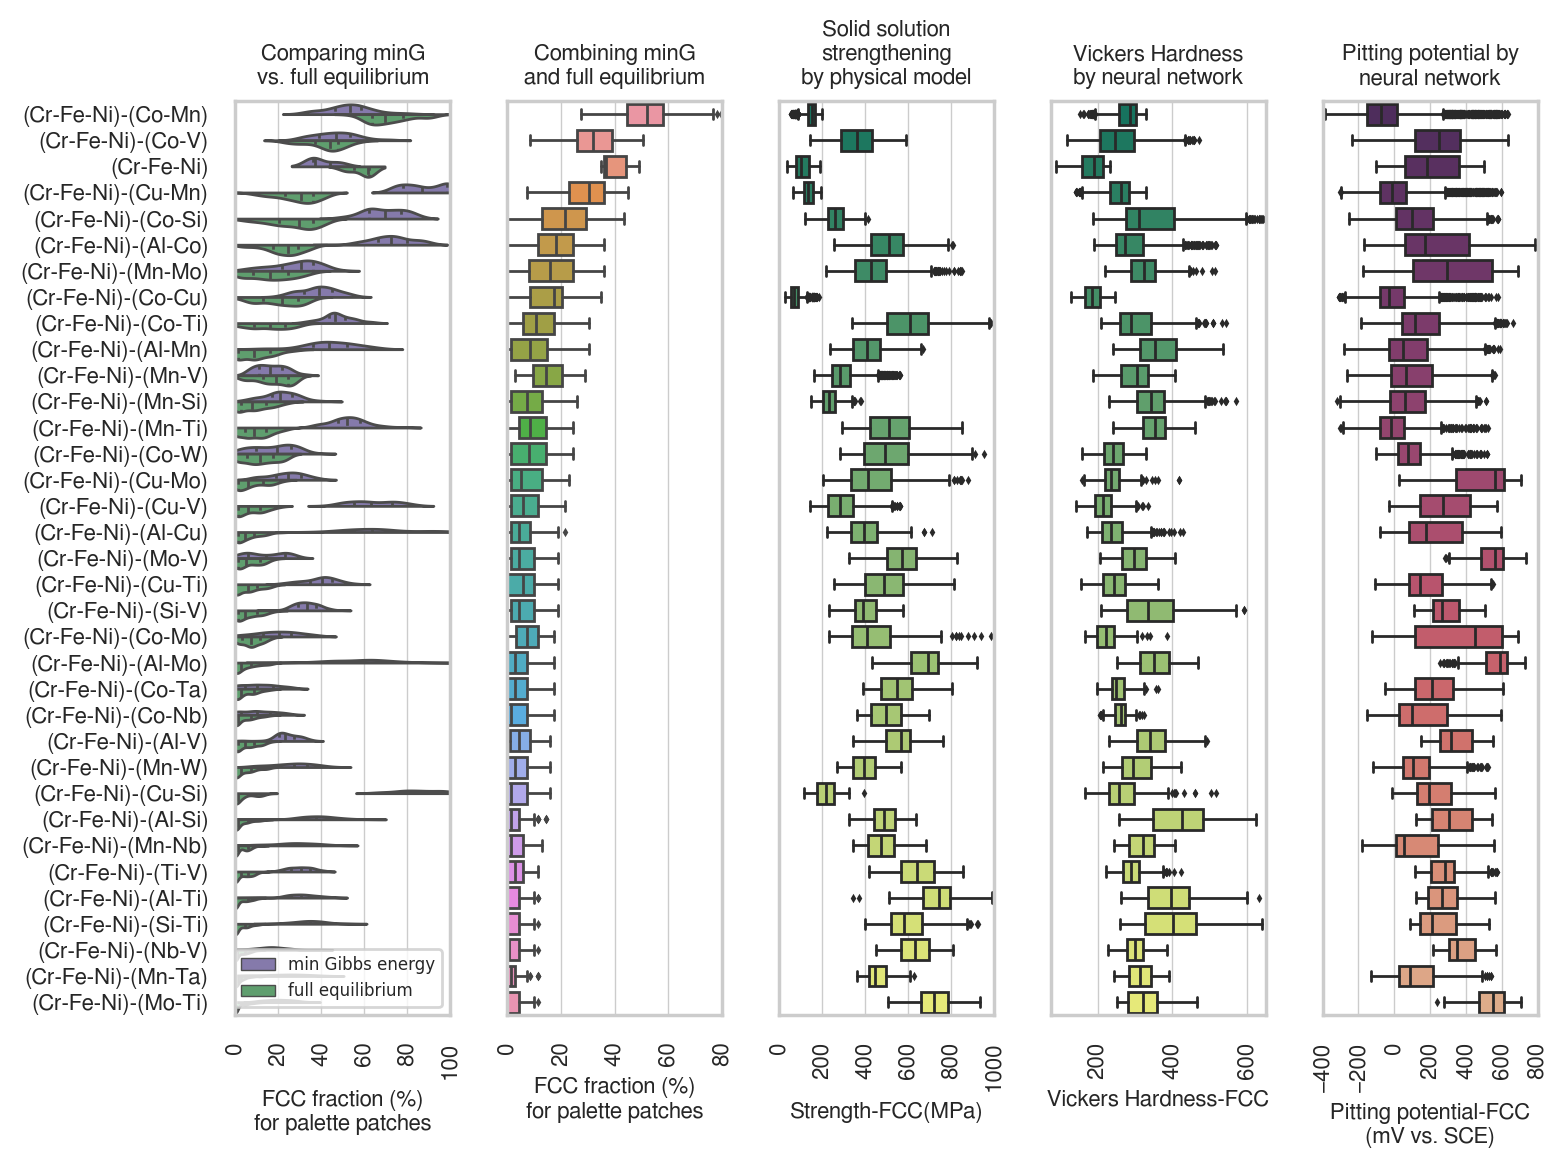

In [66]:
sns_plot(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35,
         figsize=(8, 6), rotation=90, fig_name='sns_plot_35.pdf')

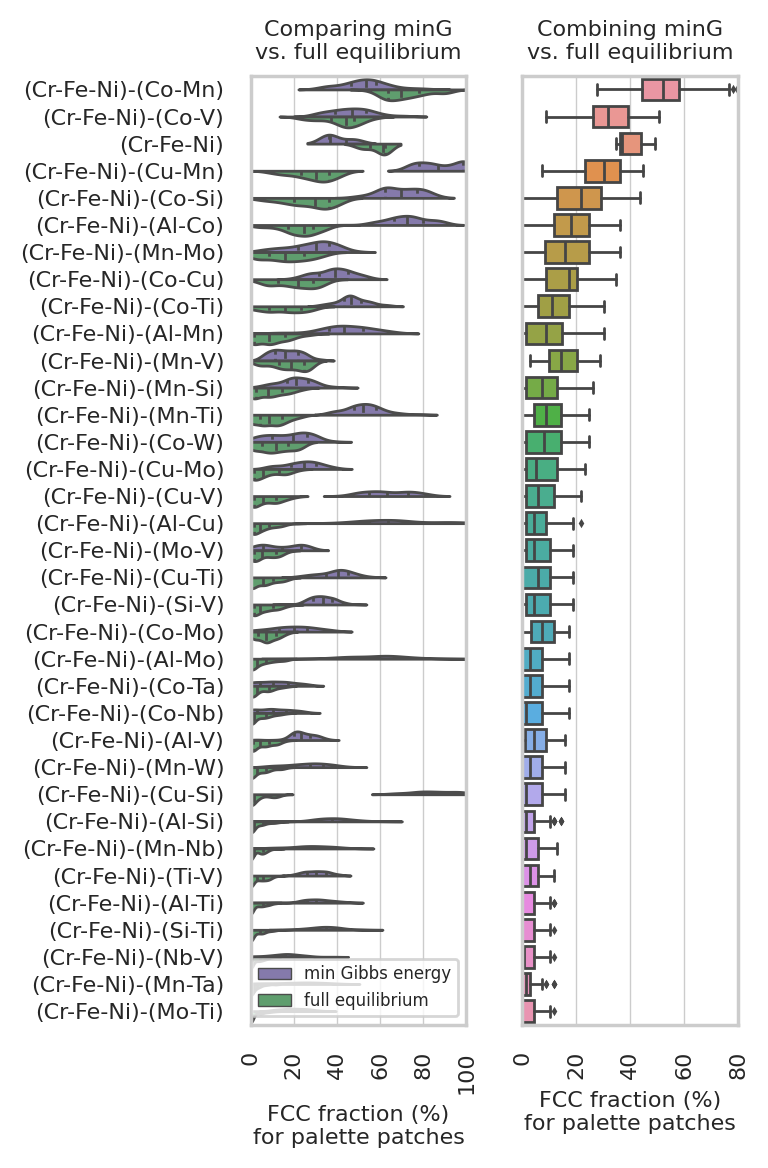

In [67]:
def sns_plot_minG_FullEquil(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35, figsize=(8, 6), rotation=45, fig_name='sns_plot_35.pdf'):

    fig, axs = plt.subplots(ncols=2, figsize=figsize, dpi=200)
    sns.set_theme(style="whitegrid", rc={
                  "axes.grid": True, "grid.linewidth": 0.5})
    font_size = 8

    sns.violinplot(data=df_fcc_sns_35, x="Gmin_vs_eq_FCC_fraction", y="compo_A_B_C_D_E", hue="minG vs.full equil.",
                   split=True, inner="quart", linewidth=1,
                   palette={"min Gibbs energy": "m", "full equilibrium": "g"}, ax=axs[0])
    axs[0].set_title("Comparing minG\nvs. full equilibrium",
                     fontsize=font_size)
    axs[0].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[0].set_ylabel(None)
    axs[0].legend(fontsize=font_size-2, loc='lower right')
    axs[0].set_xlim([0, 100])
    axs[0].set_xticks(range(0, 101, 20))
    axs[0].tick_params(axis='x', rotation=rotation)
    axs[0].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_fcc_sns_35, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[1])  # palette="summer"
    axs[1].set_title("Combining minG\nvs. full equilibrium",
                     fontsize=font_size)
    axs[1].set_xlabel('FCC fraction (%)\nfor palette patches',
                      fontsize=font_size)
    axs[1].set_ylabel(None)
    axs[1].set_xlim([0, 80])
    axs[1].set_xticks(range(0, 81, 20))
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis='x', rotation=rotation)
    axs[1].tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()
    # plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

sns_plot_minG_FullEquil(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35,
                        figsize=(4, 6), rotation=90, fig_name='sns_plot_35_minG_FullEquil.pdf')

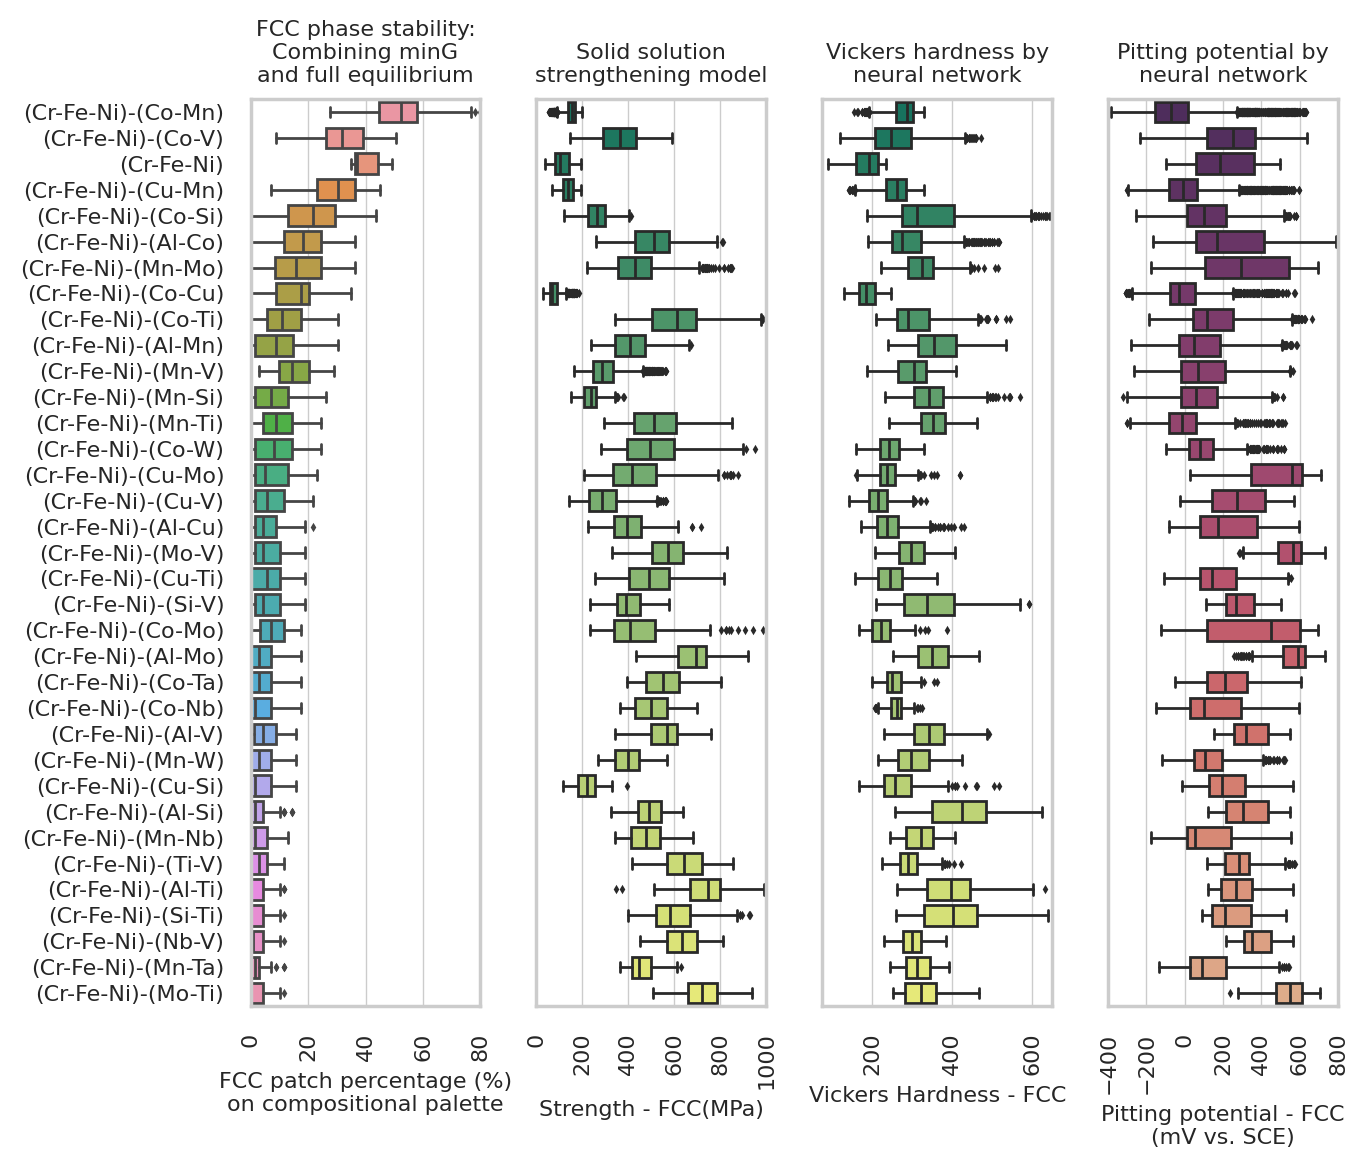

In [68]:
def sns_plot_new(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35, figsize=(8, 6), rotation=45, fig_name='sns_plot_35.pdf'):

    fig, axs = plt.subplots(ncols=4, figsize=figsize, dpi=200)
    sns.set_theme(style="whitegrid", rc={
                  "axes.grid": True, "grid.linewidth": 0.5})
    font_size = 8

    sns.boxplot(data=df_fcc_sns_35, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[0])  # palette="summer"
    axs[0].set_title("FCC phase stability:\nCombining minG\nand full equilibrium",
                     fontsize=font_size)
    axs[0].set_xlabel('FCC patch percentage (%)\non compositional palette',
                      fontsize=font_size)
    axs[0].set_ylabel(None)
    axs[0].set_xlim([0, 80])
    axs[0].set_xticks(range(0, 81, 20))
    # axs[0].set_yticklabels([])
    axs[0].tick_params(axis='x', rotation=rotation)
    axs[0].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_SSS_sns_35, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[1], palette="summer")
    axs[1].set_title(
        'Solid solution\nstrengthening model', fontsize=font_size)
    axs[1].set_xlabel('Strength - FCC(MPa)', fontsize=font_size)
    axs[1].set_ylabel(None)
    axs[1].set_yticklabels([])
    axs[1].set_xlim([0, 1000])
    axs[1].set_xticks(range(0, 1001, 200))
    axs[1].tick_params(axis='x', rotation=rotation)
    axs[1].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_35, x="H1_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[2], palette="summer")
    axs[2].set_title('Vickers hardness by\nneural network', fontsize=font_size)
    axs[2].set_xlabel('Vickers Hardness - FCC', fontsize=font_size)
    axs[2].set_ylabel(None)
    axs[2].set_yticklabels([])
    axs[2].set_xticks(range(0, 601, 200))
    axs[2].set_xlim([75, 650])
    axs[2].tick_params(axis='x', rotation=rotation)
    axs[2].tick_params(axis='both', labelsize=font_size)

    sns.boxplot(data=df_H1_C2_sns_35, x="C2_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="flare_r")
    # sns.despine(left=True, ax=axs[2])
    axs[3].set_title(
        'Pitting potential by\nneural network', fontsize=font_size)
    axs[3].set_xlabel('Pitting potential - FCC\n(mV vs. SCE)',
                      fontsize=font_size)
    axs[3].set_ylabel(None)
    axs[3].set_yticklabels([])
    axs[3].set_xticks(range(-400, 801, 200))
    axs[3].set_xlim([-400, 800])
    axs[3].tick_params(axis='x', rotation=rotation)
    axs[3].tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()


sns_plot_new(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35,
             figsize=(7, 6), rotation=90, fig_name='sns_plot_35_new.pdf')

### All alloys by max FCC fraction per palette


In [69]:
df_H1_C2_sns.columns

Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FCC', 'H1_new_pred_KFold_std_FCC',
       'C2_new_pred_KFold_mean_FCC', 'C2_new_pred_KFold_std_FCC', 'V', 'Cu',
       'Si', 'Al', 'Mo', 'Ti', 'W', 'Ta', 'Nb'],
      dtype='object')

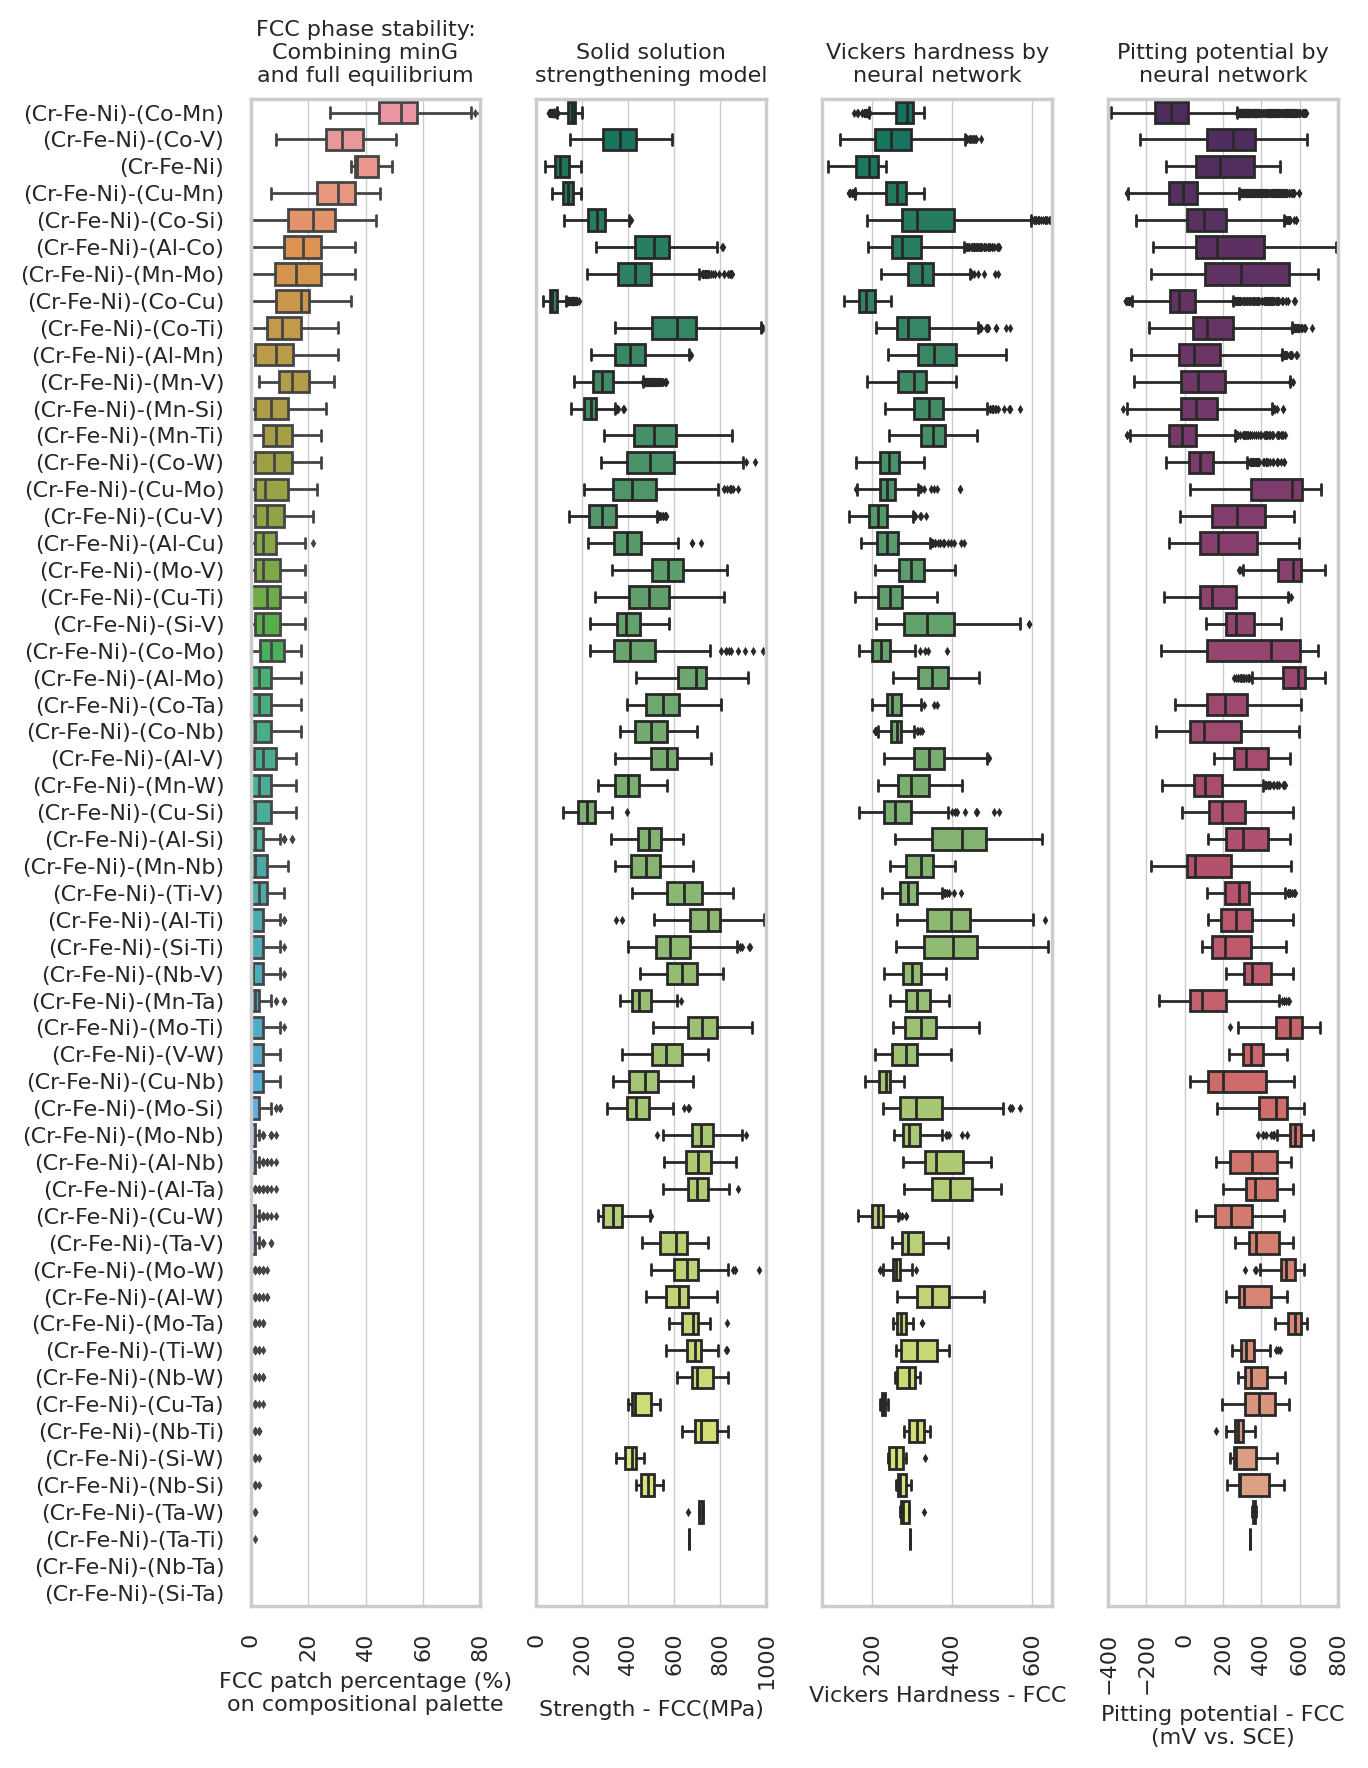

In [70]:
sns_plot_new(df_fcc_sns, df_SSS_sns, df_H1_C2_sns,
         figsize=(7, 9), rotation=90, 
         fig_name='sns_plot_full_new.pdf')

### Relative Standard Deviation


In [71]:
def add_norm_by_range_cols(
    df,
    H1_mean_col='H1_new_pred_KFold_mean_FCC',
    H1_std_col ='H1_new_pred_KFold_std_FCC',
    C2_mean_col='C2_new_pred_KFold_mean_FCC',
    C2_std_col ='C2_new_pred_KFold_std_FCC',
    rng_quantiles=(0, 100),              # use full range by default
    H1_rng_scale=None, C2_rng_scale=None  # pass scales to keep consistency across subsets
):
    """
    Adds only the min–max–normalised uncertainty columns:
      - H1_std_norm_rng, H1_std_norm_rng_pct
      - C2_std_norm_rng, C2_std_norm_rng_pct

    Scales are computed from the global range of the *predicted means*:
      - If rng_quantiles == (0, 100): uses full min–max (includes outliers).
      - Else: uses the specified percentile spread (q_high - q_low).
    If explicit scales are provided, they are used directly (recommended for subsets).
    Chosen scales and quantiles are saved in df.attrs.
    """
    df = df.copy()
    q_low, q_high = rng_quantiles

    def _range_scale(series, preset_scale=None):
        if preset_scale is not None:
            return float(preset_scale)

        vals = series.to_numpy()

        if q_low == 0 and q_high == 100:
            lo = np.nanmin(vals)
            hi = np.nanmax(vals)
        else:
            lo = np.nanpercentile(vals, q_low)
            hi = np.nanpercentile(vals, q_high)

        scale = hi - lo

        # final safety nets if degenerate
        if not np.isfinite(scale) or scale <= 0:
            scale = 1.0
        return float(scale)

    # compute or reuse global scales
    H1_scale = _range_scale(df[H1_mean_col], H1_rng_scale)
    C2_scale = _range_scale(df[C2_mean_col], C2_rng_scale)

    # add normalised-by-range columns
    df["H1_std_norm_rng"]     = df[H1_std_col] / H1_scale
    df["H1_std_norm_rng_pct"] = 100.0 * df["H1_std_norm_rng"]
    df["C2_std_norm_rng"]     = df[C2_std_col] / C2_scale
    df["C2_std_norm_rng_pct"] = 100.0 * df["C2_std_norm_rng"]

    # stash params for reuse
    df.attrs['rng_q_low']    = q_low
    df.attrs['rng_q_high']   = q_high
    df.attrs['H1_rng_scale'] = H1_scale
    df.attrs['C2_rng_scale'] = C2_scale

    return df


In [72]:
# Compute scales once on the full set
df_H1_C2_sns = add_norm_by_range_cols(df_H1_C2_sns)

# Reuse the exact same scales for the 35-subset
df_H1_C2_sns_35 = add_norm_by_range_cols(
    df_H1_C2_sns_35,
    H1_rng_scale=df_H1_C2_sns.attrs['H1_rng_scale'],
    C2_rng_scale=df_H1_C2_sns.attrs['C2_rng_scale'],
    rng_quantiles=(df_H1_C2_sns.attrs['rng_q_low'], df_H1_C2_sns.attrs['rng_q_high']),
)


In [73]:
print(df_H1_C2_sns.columns, '\n', df_H1_C2_sns_35.columns)

Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FCC', 'H1_new_pred_KFold_std_FCC',
       'C2_new_pred_KFold_mean_FCC', 'C2_new_pred_KFold_std_FCC', 'V', 'Cu',
       'Si', 'Al', 'Mo', 'Ti', 'W', 'Ta', 'Nb', 'H1_std_norm_rng',
       'H1_std_norm_rng_pct', 'C2_std_norm_rng', 'C2_std_norm_rng_pct'],
      dtype='object') 
 Index(['Unnamed: 0', 'Fe', 'Cr', 'Ni', 'Co', 'Mn', 'ShearModulus_eff',
       'PoissonsRatio_eff', 'delta_prime_misfit', 'sigma_SSS', 'Gmin_FCC',
       'eq_FCC', 'Gmin_eq_FCC', 'sigma_SSS_FCC', 'compo_A_B_C_D_E',
       'H1_new_pred_KFold_mean', 'H1_new_pred_KFold_std',
       'C2_new_pred_KFold_mean', 'C2_new_pred_KFold_std',
       'H1_new_pred_KFold_mean_FC

In [74]:
def sns_plot_new_uncertainty(df_fcc_sns_35, df_SSS_sns_35, df_H1_C2_sns_35,
                             figsize=(9, 9), rotation=45, fig_name='sns_plot_35_uncertainty.pdf'):

    fig, axs = plt.subplots(ncols=6, figsize=figsize, dpi=200)
    sns.set_theme(style="whitegrid", rc={"axes.grid": True, "grid.linewidth": 0.5})
    font_size = 7

    # (1) FCC phase stability
    sns.boxplot(data=df_fcc_sns_35, x="Gmin_eq_FCC_fraction", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[0])
    axs[0].set_title("FCC phase stability:\nCombining minG\nand full equilibrium", fontsize=font_size)
    axs[0].set_xlabel('FCC patch percentage (%)\non compositional palette', fontsize=font_size)
    axs[0].set_ylabel(None)
    axs[0].set_xlim([0, 80]); axs[0].set_xticks(range(0, 81, 20))
    axs[0].tick_params(axis='x', rotation=rotation)
    axs[0].tick_params(axis='both', labelsize=font_size)

    # (2) Solid solution strengthening
    sns.boxplot(data=df_SSS_sns_35, x="sigma_SSS_FCC", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[1], palette="summer")
    axs[1].set_title('Solid solution\nstrengthening model', fontsize=font_size)
    axs[1].set_xlabel('Strength - FCC (MPa)', fontsize=font_size)
    axs[1].set_ylabel(None); axs[1].set_yticklabels([])
    axs[1].set_xlim([0, 1000]); axs[1].set_xticks(range(0, 1001, 200))
    axs[1].tick_params(axis='x', rotation=rotation)
    axs[1].tick_params(axis='both', labelsize=font_size)

    # (3) Hardness mean
    sns.boxplot(data=df_H1_C2_sns_35, x="H1_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[2], palette="summer")
    axs[2].set_title('Vickers hardness by\nneural network', fontsize=font_size)
    axs[2].set_xlabel('Vickers Hardness - FCC', fontsize=font_size)
    axs[2].set_ylabel(None); axs[2].set_yticklabels([])
    axs[2].set_xticks(range(0, 601, 200)); axs[2].set_xlim([75, 650])
    axs[2].tick_params(axis='x', rotation=rotation)
    axs[2].tick_params(axis='both', labelsize=font_size)

    # (4) Pitting potential mean
    sns.boxplot(data=df_H1_C2_sns_35, x="C2_new_pred_KFold_mean_FCC",
                y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="flare_r")
    axs[3].set_title('Pitting potential by\nneural network', fontsize=font_size)
    axs[3].set_xlabel('Pitting potential - FCC\n(mV vs. SCE)', fontsize=font_size)
    axs[3].set_ylabel(None); axs[3].set_yticklabels([])
    axs[3].set_xticks(range(-400, 801, 200)); axs[3].set_xlim([-400, 800])
    axs[3].tick_params(axis='x', rotation=rotation)
    axs[3].tick_params(axis='both', labelsize=font_size)

    # (5) Hardness uncertainty (normalised)
    sns.boxplot(data=df_H1_C2_sns_35, x="H1_std_norm_rng_pct", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[4], palette="summer")
    axs[4].set_title('Hardness uncertainty\nnorm. std (%)', fontsize=font_size)
    axs[4].set_xlabel('Normalised std (%)', fontsize=font_size)
    axs[4].set_ylabel(None); axs[4].set_yticklabels([])
    axs[4].set_xticks(range(0, 26, 5)); axs[4].set_xlim([0, 25])
    axs[4].tick_params(axis='x', rotation=rotation)
    axs[4].tick_params(axis='both', labelsize=font_size)

    # (6) Pitting potential uncertainty (normalised)
    sns.boxplot(data=df_H1_C2_sns_35, x="C2_std_norm_rng_pct", y="compo_A_B_C_D_E",
                linewidth=1, fliersize=1, ax=axs[5], palette="flare_r")
    axs[5].set_title('Pitting potential\nuncertainty\nnorm. std (%)', fontsize=font_size)
    axs[5].set_xlabel('Normalised std (%)', fontsize=font_size)
    axs[5].set_ylabel(None); axs[5].set_yticklabels([])
    axs[5].set_xticks(range(0, 26, 5)); axs[5].set_xlim([0, 25])
    axs[5].tick_params(axis='x', rotation=rotation)
    axs[5].tick_params(axis='both', labelsize=font_size)

    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()


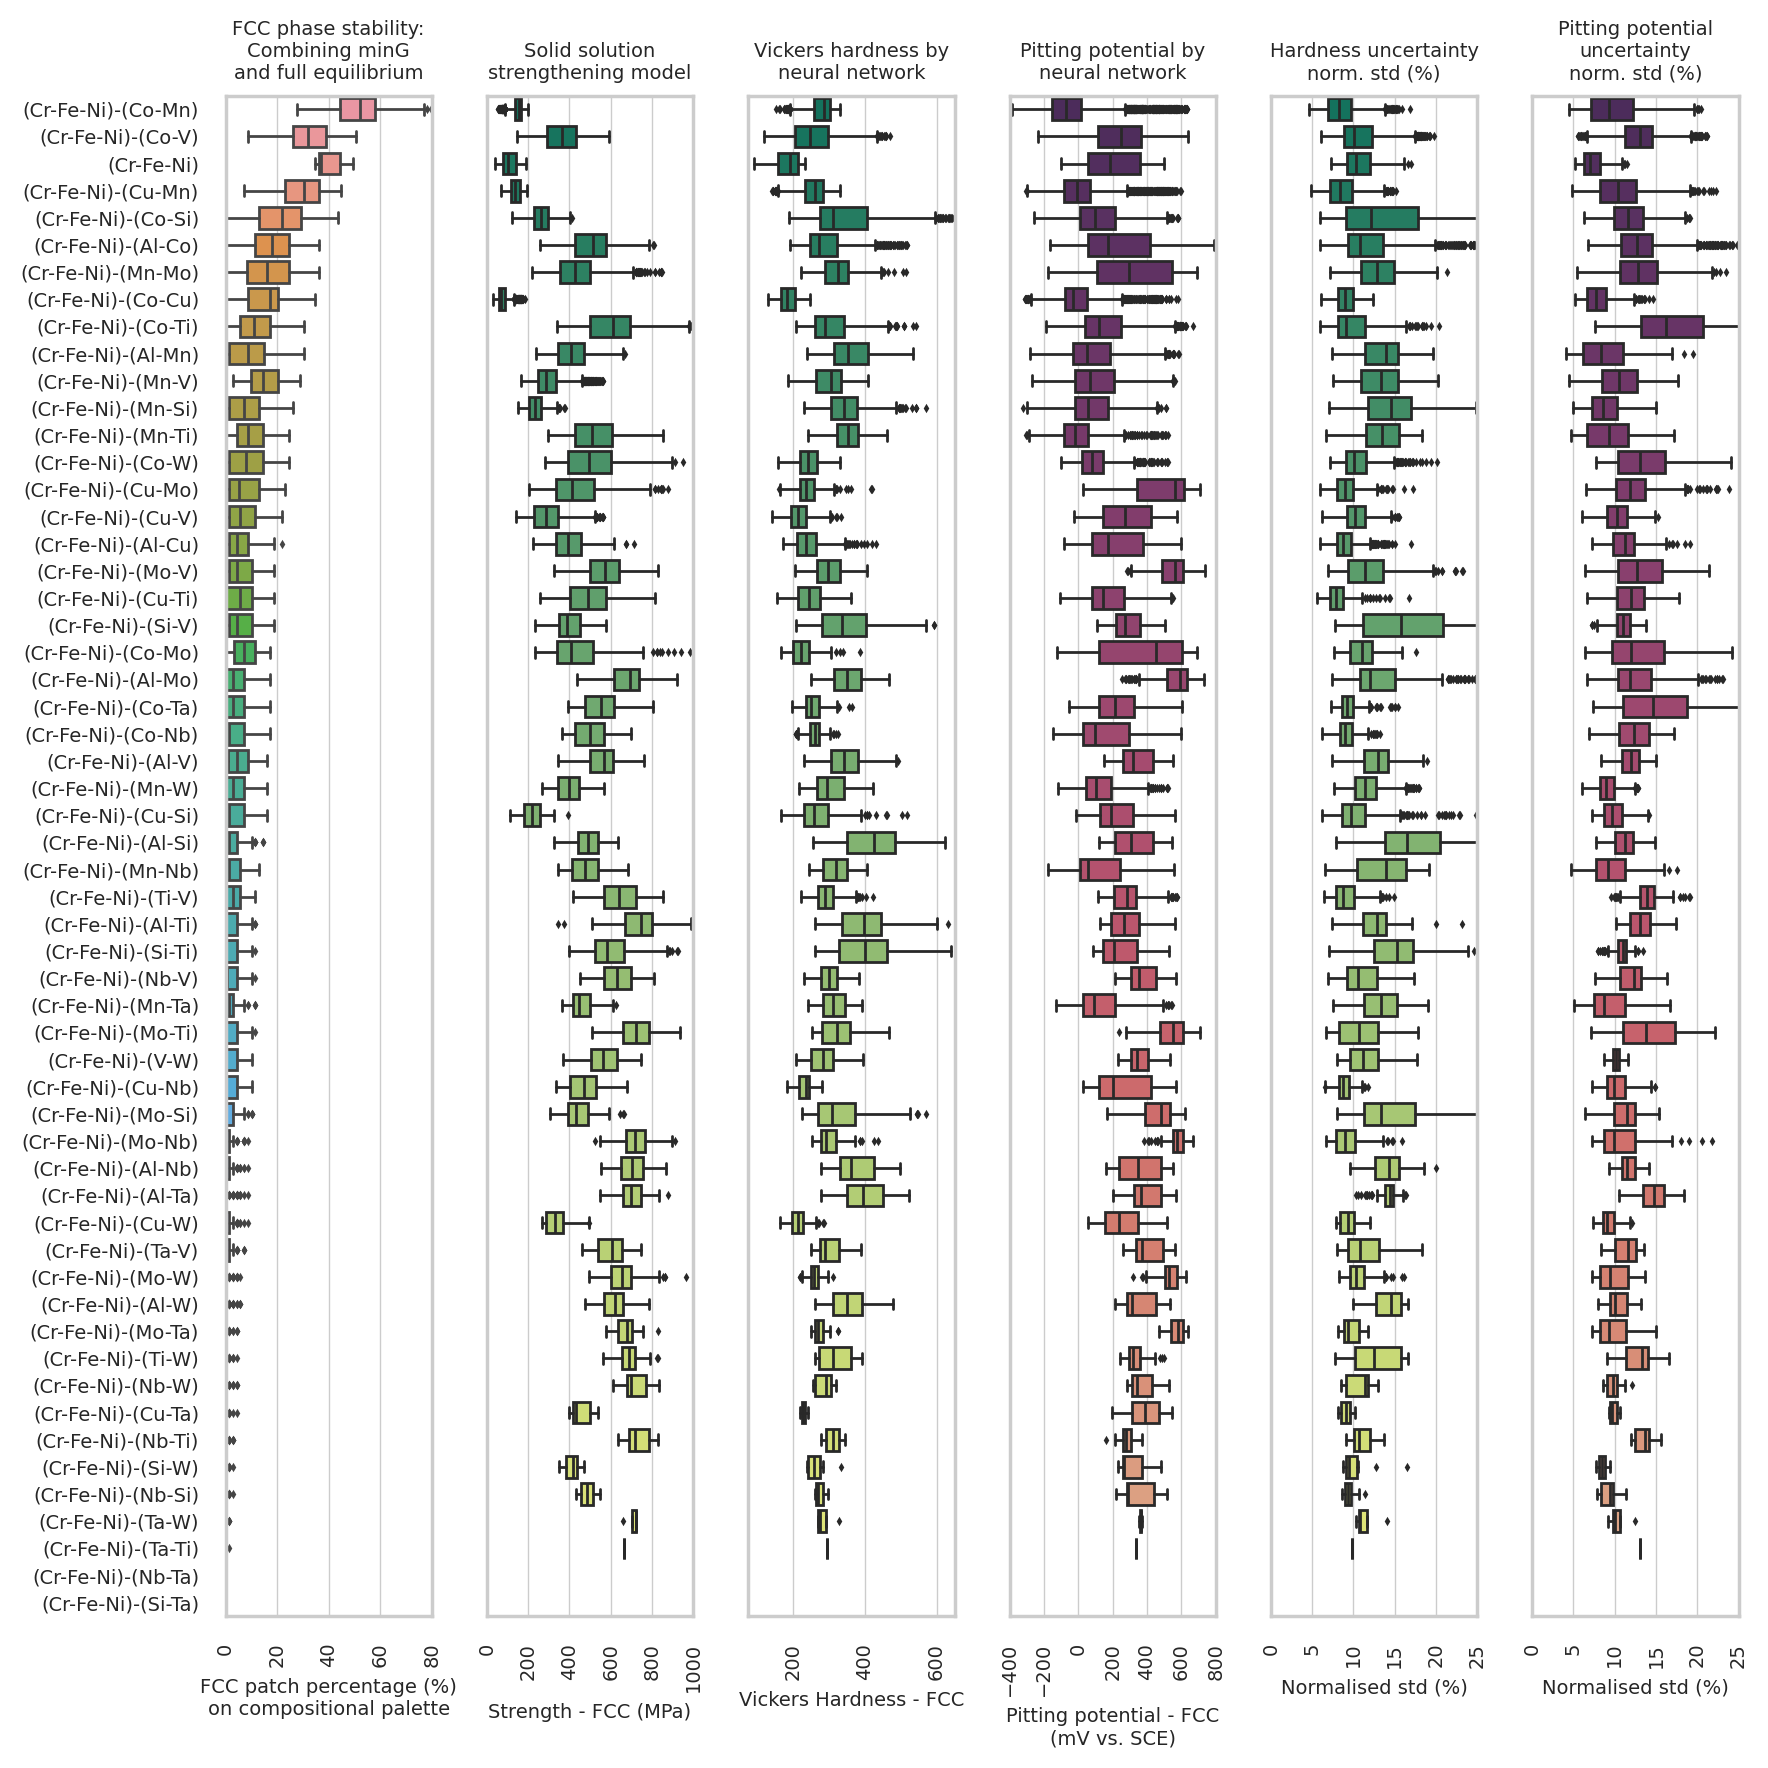

In [75]:
sns_plot_new_uncertainty(df_fcc_sns, df_SSS_sns, df_H1_C2_sns,
                         figsize=(9, 9), rotation=90,
                         fig_name='sns_plot_full_new_uncertainty.pdf')


In [76]:
# import matplotlib
# matplotlib.rcParams['font.family'] = 'FreeSans'

# fig, axs = plt.subplots(ncols=4, figsize=(6, 5), dpi=200)
# sns.set_theme(style="whitegrid")
# font_size = 7

# sns.boxplot(data=df_H1_C2_sns_35, x="H1_new_pred_KFold_mean_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[0], palette="summer")
# # sns.despine(left=True, ax=axs[2])
# axs[0].set_title('Vickers Hardness by ANN: mean', fontsize=font_size)
# axs[0].set_xlabel('Vickers Hardness', fontsize=font_size)
# axs[0].set_ylabel(None)
# axs[0].set_yticklabels([])
# axs[0].set_xlim([0, 600])
# axs[0].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_35, x="H1_new_pred_KFold_std_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[1], palette="summer")
# # sns.despine(left=True, ax=axs[2])
# axs[1].set_title('Vickers Hardness by ANN: std', fontsize=font_size)
# axs[1].set_xlabel('Vickers Hardness', fontsize=font_size)
# axs[1].set_ylabel(None)
# axs[1].set_yticklabels([])
# axs[1].set_xlim([0, 300])
# axs[1].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_35, x="C2_new_pred_KFold_mean_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[2], palette="flare_r")
# # sns.despine(left=True, ax=axs[2])
# axs[2].set_title('Corrosion pitting potential by ANN: mean',
#                  fontsize=font_size)
# axs[2].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
# axs[2].set_ylabel(None)
# axs[2].set_yticklabels([])
# axs[2].set_xlim([-300, 800])
# axs[2].tick_params(axis='both', labelsize=font_size)

# sns.boxplot(data=df_H1_C2_sns_35, x="C2_new_pred_KFold_std_FCC",
#             y="compo_A_B_C_D_E", linewidth=1, fliersize=1, ax=axs[3], palette="flare_r")
# # sns.despine(left=True, ax=axs[2])
# axs[3].set_title('Corrosion pitting potential by ANN: std', fontsize=font_size)
# axs[3].set_xlabel('Pitting potential (mV vs SCE)', fontsize=font_size)
# axs[3].set_ylabel(None)
# axs[3].set_yticklabels([])
# axs[3].set_xlim([0, 400])
# axs[3].tick_params(axis='both', labelsize=font_size)

# plt.tight_layout()
# # plt.savefig('sns_plot_35', bbox_inches='tight')
# plt.show()